# Session 8 exercises

These are sample answers for the in-class exercises in Session 8 of PHAS0030.  You should make sure that you can do these yourself! The further work exercises will be in a separate notebook.

In [1]:
# We always start with appropriate imports; note the use of the IPython magic
# command to set up Matplotlib within the notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Create a random number generator
rng = np.random.default_rng()

## 3. Pseudo-random numbers

### Question 1

Note the line `Nsteps = int(tmax/dt)` where we calculate the number of timesteps, but have to make the variable an integer (the `range` function requires an integer input).  This may also cause issues with indexing, which also requires integers (see the next question for more on this).

In [2]:
Natoms = 1000
tmax = 1000       # seconds
dt = 0.1          # seconds
# Find number of timesteps and convert to integer
Nsteps = int(tmax/dt)
tau_Tl = 3.053*60 # half-life in seconds
t0_Tl  = tau_Tl/np.log(2.0)

# Store populations at each timestep
pop_Tl = np.zeros(Nsteps+1,dtype=int)
pop_Pb = np.zeros(Nsteps+1,dtype=int)
# Initial condition
pop_Tl[0] = Natoms
# Decay probability per timestep
prob_decay = 1.0 - np.exp(-dt/t0_Tl)

for i in range(Nsteps):
    # Array with chance for each Tl to decay
    prob_samp = rng.random(pop_Tl[i])
    # Sum to find number that decay
    decay_total = np.sum(np.where(prob_samp<prob_decay,1,0))
    # Update populations
    pop_Tl[i+1] = pop_Tl[i] - decay_total
    pop_Pb[i+1] = pop_Pb[i] + decay_total

Text(0.5, 1.0, 'Decay of sample of Tl atoms')

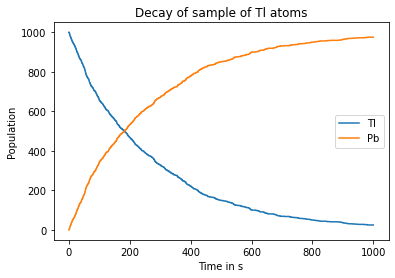

In [3]:
tarr = np.arange(0,tmax+dt,dt)
plt.plot(tarr,pop_Tl,label='Tl')
plt.plot(tarr,pop_Pb,label='Pb')
plt.legend()
plt.xlabel("Time in s")
plt.ylabel("Population")
plt.title("Decay of sample of Tl atoms")

We see the expected exponential decay in Tl atoms, with the appropriate increase in Pb atoms.

### Question 2

Note that if you are wanting to use the trajectory storage for indexing, you'll need to ensure that it stores integers (you can add the argument `dtype=int` when creating the storage with `np.zeros`).  The way that `plt.imshow` displays data is rotated by ninety degrees compared to `plt.plot` so in the second figure I have transposed the trajectory.

In [4]:
side = 151
mid = 75
# Trajectory storage: we might choose to make it an integer
# using the argument dtype=int if we use this for indexing
traj = np.zeros((side,side))
this_x = mid
this_y = mid
traj[this_x,this_y] = 1
Nsteps = 10000
# Neighbours
neigh = np.array([[-1,0],[1,0],[0,-1],[0,1]])

# Storage for the path
line = np.zeros((Nsteps+1,2))
line[0] = np.array([this_x,this_y])
for i in range(Nsteps):
    # Pick neighbour
    neigh0 = rng.integers(4)
    this_x += neigh[neigh0,0]
    this_y += neigh[neigh0,1]
    # Hard-wall boundaries
    if(this_x>side-1):
        this_x -= 2
    if(this_y>side-1):
        this_y -= 2
    if(this_x<0):
        this_x += 2
    if(this_y<0):
        this_y += 2
    # Update trajectory and path
    traj[this_x,this_y] += 1
    line[i+1] = np.array([this_x,this_y])

Text(0.5, 1.0, 'Map of random walk')

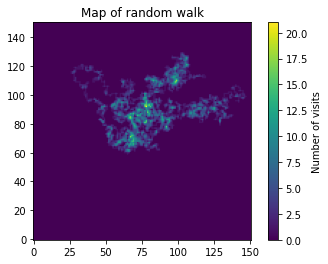

In [5]:
# Plot showing number of times each point was visited
plt.imshow(traj,origin='lower')
plt.colorbar(label='Number of visits')
plt.title("Map of random walk")

Text(0.5, 1.0, 'Path and probability distribution')

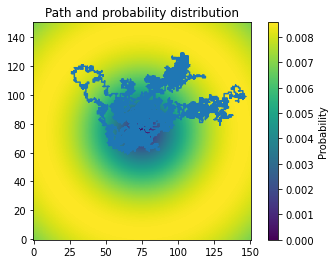

In [6]:
# Plot probability distribution for Nsteps
x = np.linspace(-mid,mid,side)
y = np.linspace(-mid,mid,side)
x2d, y2d = np.meshgrid(x,y)
prob_r = 2 * np.sqrt(x2d*x2d + y2d*y2d) * np.exp(-(x2d*x2d+y2d*y2d)/Nsteps) / Nsteps
plt.imshow(prob_r,origin='lower')
plt.colorbar(label='Probability')
# Plot path taken by particle
# I have transposed x and y to match the imshow plot above
plt.plot(line[:,1],line[:,0])
plt.title('Path and probability distribution')

We see that the location of the particle fits quite well with the probability distribution.

## 4. Probability distributions

### Question 1

In [7]:
def sample_dist(Nsamp,mu,sigma):
    """Average Nsamp samples from uniform distribution
    
    Inputs:
    Nsamp  Number of samples
    mu     Mean of distribution
    sigma  Width of distribution
    
    Output:
    Mean of Nsamp samples
    """
    # Calculate width
    width = np.sqrt(3*Nsamp)*sigma
    # Pass limits to uniform generator
    samp = rng.uniform(mu-width, mu+width,Nsamp)
    return(np.sum(samp)/Nsamp)

### Question 2

In [8]:
Ndist = 100000
Nsamp = 10
mu = 0.0
sigma = 1.0
table = np.zeros(Ndist)
for i in range(Ndist):
    table[i] = sample_dist(Nsamp,mu,sigma)

Mean: 0.006640189103871639
SD:   1.000050023805849


Text(0.5, 1.0, 'Testing central limit theorem')

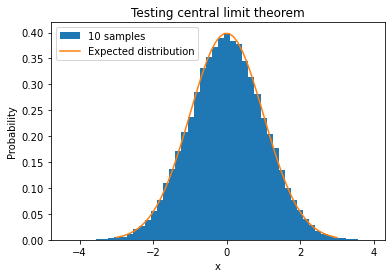

In [9]:
# Output mean & standard deviation
print(f"Mean: {np.mean(table)}")
print(f"SD:   {np.std(table)}")

# Plot histogram
a = plt.hist(table,bins=50,density=True,label=f'{Nsamp} samples')

# Plot expected distribution
x = np.linspace(-3,3)
sdist = 1.0
plt.plot(x,np.exp(-x*x/(2*sdist*sdist))/np.sqrt(2*np.pi*sdist*sdist),label='Expected distribution')
plt.xlabel("x")
plt.ylabel("Probability")
plt.legend()
plt.title("Testing central limit theorem")

I found that Ndist=10,000 was adequate but 100,000 gives a better result.  Once Nsamp>10 we get a good normal distribution.

### Question 3

In [10]:
def rejection_method_uniform(n_samples,a,b,h):
    """Rejection method drawing from uniform x from a to b, maximum h
    
    Inputs:
    n_samples  Number of samples
    a, b       Limits of uniform distribution
    h          Height of uniform distribution
    
    Output:
    result     Array of n_samples numbers
    """
    result = np.zeros(n_samples)
    n_accept = 0
    n_counts = 0
    for i in range(n_samples):
        reject = True
        while reject:
            n_counts += 1
            x = rng.uniform(a,b)
            z = h # p(x) is uniform
            qx = (1+x*x)*np.exp(-0.5*x*x)/(2*np.sqrt(2*np.pi))
            nx = z*rng.random()
            if(nx<qx):
                reject = False
                result[n_accept] = x
                n_accept += 1
    print("Ran ",n_counts," tests for ",n_samples," samples")
    return result

### Question 4

In [11]:
Nsamp = 100000
samp_uni   = rejection_method_uniform(Nsamp,-5,5,0.5)

Ran  499825  tests for  100000  samples


Text(0.5, 1.0, 'Testing rejection method')

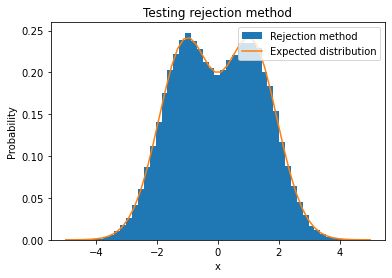

In [12]:
# Histogram of rejection method
a = plt.hist(samp_uni,bins=50,density=True,label='Rejection method')

# Set up target distribution
xplot = np.linspace(-5,5)
xplot2 = xplot*xplot
targ = (1+xplot2)*np.exp(-0.5*xplot2)/(2*np.sqrt(2*np.pi))
plt.plot(xplot,targ,label='Expected distribution')
plt.xlabel("x")
plt.ylabel("Probability")
plt.legend()
plt.title("Testing rejection method")

We see that the histogram fits the target distribution well, though the method is quite inefficient with roughly 80% of numbers discarded.

## 5. Monte Carlo methods

### Question 1

In [13]:
def func_int(x):
    """Function to be integrated: x^{-1/3} + x/10"""
    return x**(-1/3) + 0.1*x

### Question 2

In [14]:
for Nsamp in [1e3, 1e4, 1e5, 1e6]:
    total = 0.0
    total = np.sum(func_int(rng.random(int(Nsamp))))
    print("Integral is ",total/Nsamp," with ",Nsamp," samples")
    print("Error is ",total/Nsamp - 1.55)

Integral is  1.5501612362863215  with  1000.0  samples
Error is  0.00016123628632147557
Integral is  1.5676686534566935  with  10000.0  samples
Error is  0.01766865345669344
Integral is  1.5470348100907443  with  100000.0  samples
Error is  -0.002965189909255761
Integral is  1.5488226687550417  with  1000000.0  samples
Error is  -0.001177331244958335


We see that the result is reliable when we reach 100,000 samples, but not really before that (just over 1% error is unlikely to be acceptable).

Note also that if we were to use a `for` loop to calculate the sum (`total` in this case) the calculation is *much* slower.

### Question 3

In [15]:
for Nsamp in [1e3, 1e4, 1e5, 1e6]:
    thisy = rng.random(int(Nsamp))
    thisx = thisy**1.5
    total = np.sum(func_int(thisx)/(2.0/(3.0*thisx**(1/3))))
    print("Integral is ",total/Nsamp," with ",Nsamp," samples")
    print("Error is ",total/Nsamp - 1.55)

Integral is  1.551942642902598  with  1000.0  samples
Error is  0.0019426429025979353
Integral is  1.5497627032566361  with  10000.0  samples
Error is  -0.00023729674336392392
Integral is  1.5499654262610763  with  100000.0  samples
Error is  -3.457373892379323e-05
Integral is  1.5500431427468577  with  1000000.0  samples
Error is  4.314274685768282e-05


It's clear that the error found with importance sampling converges much faster than with uniform sampling.  The result with 1,000 samples is reliable.

## 6. Monte Carlo simulations

### Question 1

In [16]:
boxlen = 50
B_over_kT = 0.4
J_over_kT = 0.0
spins = (-1)**rng.integers(0,2,size=(boxlen,boxlen))

Text(0.5, 1.0, 'Initial spins')

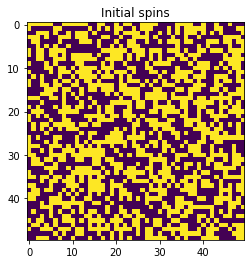

In [17]:
plt.imshow(spins)
plt.title('Initial spins')

### Question 2

In [18]:
# Create sum over neighbours
sum_neigh_spins = (np.roll(spins,1,axis=0)+np.roll(spins,-1,axis=0)+
                   np.roll(spins,1,axis=1)+np.roll(spins,-1,axis=1))
etot = -np.sum(spins*(B_over_kT + J_over_kT*sum_neigh_spins))
print("Starting energy is ",etot)

Starting energy is  4.000000000000003


As the starting conformation is random, this initial energy has little significance

### Question 3

The easiest way to write the update is just to calculate the energy twice, as shown in this routine `update`.  However, we can just calculate the energy change locally (just for the flipped spin) as shown in the routine `update_local` below.

In [19]:
def update(i,j):
    """Update move for MC Ising model
    
    Assumes that the 2D array spins is defined externally
    and changes this if the Metropolis criterion is met.
    
    Inputs:
    i, j  Location of spin to flip
    
    Output:
    de    Change of energy
    """
    sum_neigh_spins = (np.roll(spins,1,axis=0)+np.roll(spins,-1,axis=0)+
                   np.roll(spins,1,axis=1)+np.roll(spins,-1,axis=1))
    e_init = -np.sum(spins*(B_over_kT + J_over_kT*sum_neigh_spins))
    # Now flip the spin
    spins[i,j] *= -1
    # Find new energy
    sum_neigh_spins = (np.roll(spins,1,axis=0)+np.roll(spins,-1,axis=0)+
                   np.roll(spins,1,axis=1)+np.roll(spins,-1,axis=1))
    e_new = -np.sum(spins*(B_over_kT + J_over_kT*sum_neigh_spins))
    de = e_new - e_init
    p = np.exp(-de)
    # restore spin if move not accepted
    if de>0 and rng.random() > p:
        spins[i,j] = -spins[i,j]
        de = 0.0
    return de

In [20]:
def update_local(i,j):
    """Update move for MC Ising model
    
    Assumes that the 2D array spins is defined externally
    and changes this if the Metropolis criterion is met.
    
    Inputs:
    i, j  Location of spin to flip
    
    Output:
    de    Change of energy
    """
    # Calculate location of neighbouring spins with periodic boundaries
    im = (i-1)%boxlen
    ip = (i+1)%boxlen
    jm = (j-1)%boxlen
    jp = (j+1)%boxlen
    sum_neigh_spins = spins[im,j] + spins[ip,j] + spins[i,jm] + spins[i,jp]
    # The change in energy accounts for flip from -1 to +1 or vice versa
    de_local = 2*spins[i,j]*(J_over_kT*sum_neigh_spins + B_over_kT)
    p = np.exp(-de)
    # flip the spin if move accepted
    if de<0 or rng.random() < p:
        spins[i,j] = -spins[i,j]
    else:
        de = 0.0
    return de

### Question 4

This took 10-15 seconds to run on my laptop.

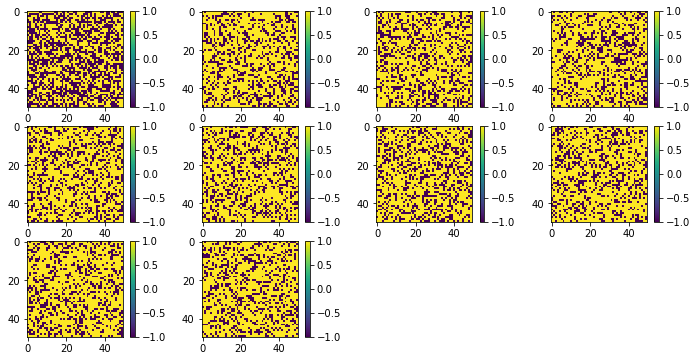

In [21]:
# Initialise storage
Nsteps = 50000
long_range_order = np.zeros(Nsteps+1)
etot = np.zeros(Nsteps+1)
long_range_order[0] = np.sum(spins)/np.size(spins)

# Initial energy
sum_neigh_spins = (np.roll(spins,1,axis=0)+np.roll(spins,-1,axis=0)+
                   np.roll(spins,1,axis=1)+np.roll(spins,-1,axis=1))
etot[0] = -np.sum(spins*(B_over_kT + J_over_kT*sum_neigh_spins))

# Figure for plots
figIsing = plt.figure(figsize=(12,6))
index = 1
spin_total = 0
spin2_total = 0
for i in range(Nsteps):
    # Choose spin at random
    this_i = rng.integers(boxlen)
    this_j = rng.integers(boxlen)
    # Test for update
    de = update(this_i,this_j)
    # Accumulate and store characteristic data
    sum_neigh_spins = (np.roll(spins,1,axis=0)+np.roll(spins,-1,axis=0)+
                       np.roll(spins,1,axis=1)+np.roll(spins,-1,axis=1))
    etot[i+1] = -np.sum(spins*(B_over_kT + J_over_kT*sum_neigh_spins))
    long_range_order[i+1] = np.sum(spins)/np.size(spins)
    spin_total += np.sum(spins)/np.size(spins)
    spin2_total += np.sum(spins)*np.sum(spins)/(np.size(spins)*np.size(spins))
    # Plot
    if i%5000==0:
        ax = figIsing.add_subplot(3,4,index)
        image = ax.imshow(spins,interpolation='none')
        plt.colorbar(mappable=image)
        index +=1 

Note that you either need to make the figure large, or use the argument `interpolation='none'` to `imshow`, otherwise it will appear to have values between -1 and 1 (i.e. not just 1 and -1) which is quite wrong.

Physically we see that the spins tend to align with the external magnetic field, though we don't see complete alignment (that would take a very long time unless we made the field much larger).

### Question 5

Text(0.5, 1.0, 'Long-range order')

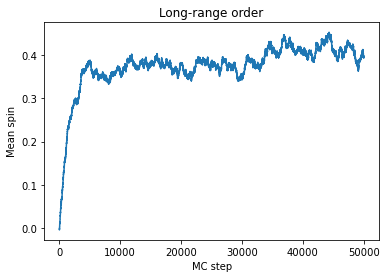

In [22]:
plt.plot(long_range_order)
plt.xlabel('MC step')
plt.ylabel('Mean spin')
plt.title('Long-range order')

Text(0.5, 1.0, 'Total energy')

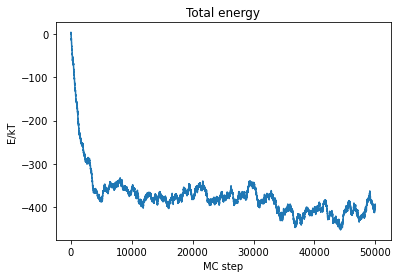

In [23]:
plt.plot(etot)
plt.xlabel('MC step')
plt.ylabel('E/kT')
plt.title('Total energy')

In [24]:
ave_spin = spin_total/(Nsteps)
print("Ave spin squared: ",spin2_total/Nsteps)
sd_spin = np.sqrt(spin2_total/Nsteps - ave_spin*ave_spin)
print("Average spin: ",ave_spin," with SD ",sd_spin)

Ave spin squared:  0.143201277222392
Average spin:  0.37444411199998695  with SD  0.05470725921606057


After an initial period when the system equilibrates, we see that the energy and average spin fluctuate around a constant value